In [ ]:
import torch
import cv2
import torchvision
from torchvision import transforms
from torch import nn, optim
from torch.nn import functional as F
from torchvision.utils import save_image
import matplotlib.pyplot as plt


In [ ]:
train_data = torchvision.datasets.MNIST('/content/', train = True,
                           transform=transforms.ToTensor(), download = True)
test_data = torchvision.datasets.MNIST('/content/', train = False,
                           transform=transforms.ToTensor(), download = True)

test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /content/
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()
    self.fc1 = nn.Linear(784,400)
    self.fc2 = nn.Linear(400,100)
    self.fc31 = nn.Linear(100,2)
    self.fc32 = nn.Linear(100,2)
    self.fc4 = nn.Linear(2, 100)
    self.fc5 = nn.Linear(100, 400)
    self.fc6 = nn.Linear(400, 784)

  def encoder(self, x):
    h1 = F.relu(self.fc1(x.view(-1,784)))
    h2 = F.relu(self.fc2(h1))
    mu = F.relu(self.fc31(h2))
    logvar = F.relu(self.fc32(h2))
    return mu, logvar

  def reparameterize(self, mu, logvar):
    # mu, logvar = self.encoder(x.view(-1,784))
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    z = mu + eps*std
    return z
  
  def decoder(self, z):
    # z = self.reparameterize(x.view(-1,784))
    l1 = F.relu(self.fc4(z))
    l2 = F.relu(self.fc5(l1))
    r_x = torch.sigmoid(self.fc6(l2))
    return r_x
  
  def forward(self, x):
    mu, logvar = self.encoder(x)
    z = self.reparameterize(mu, logvar)
    recons_x = self.decoder(z)
    return recons_x, mu, logvar



In [ ]:
device = 'cuda'
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
# model

In [ ]:
# BCE = nn.BCELoss(recons_x, x)
def loss_function(recons_x, x, mu, logvar):
  BCE = nn.BCELoss(reduction='sum')
  bce_loss = BCE(recons_x, x.view(-1,784))
  kld = -0.5*torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return bce_loss + kld

In [ ]:
epochs = 30
for epoch in range(epochs):
  model.train()
  train_loss = 0
  for id, (data, _) in enumerate(train_loader):
    data = data.to(device)
    recons_x, mu, logvar = model(data)
    optimizer.zero_grad()
    loss = loss_function(recons_x, data, mu, logvar)
    loss.backward()
    train_loss+=loss.item()
    optimizer.step()
  print('====> epochs: {}, Average train loss: {:.4f}'.format(epoch+1, train_loss/len(train_loader.dataset)))

  model.eval()
  test_loss = 0
  with torch.no_grad():
    for idtest, (data, _) in enumerate(test_loader):
      data = data.to(device)
      recons_x, mu, logvar = model(data)
      loss = loss_function(recons_x, data, mu, logvar)
      test_loss+=loss.item()
      if idtest==0:
        # print(data.size())
        results = torch.cat([data[:8], recons_x.view(64, 1, 28, 28)[:8], data[8:16], recons_x.view(64, 1, 28, 28)[8:16]])
        # img = results.cpu().detach().numpy()
        # print(img.shape())
        path = '/content/drive/MyDrive/VAE/' + 'Sample_' + str(epoch) + '.png'
        # save_image(results.cpu(), path, nrow=8)
        # cv2.imwrite(path, img)
    print('====> epochs: {}, Average test loss: {:.4f}'.format(epoch+1, test_loss/len(test_loader.dataset)))






====> epochs: 1, Average train loss: 202.5020
====> epochs: 1, Average test loss: 196.7169
====> epochs: 2, Average train loss: 196.5594
====> epochs: 2, Average test loss: 196.2574
====> epochs: 3, Average train loss: 196.2215
====> epochs: 3, Average test loss: 195.4845
====> epochs: 4, Average train loss: 195.7953
====> epochs: 4, Average test loss: 194.9540
====> epochs: 5, Average train loss: 195.4542
====> epochs: 5, Average test loss: 194.8148
====> epochs: 6, Average train loss: 195.3201
====> epochs: 6, Average test loss: 195.0427
====> epochs: 7, Average train loss: 195.1613
====> epochs: 7, Average test loss: 194.2150
====> epochs: 8, Average train loss: 195.1680
====> epochs: 8, Average test loss: 194.8487
====> epochs: 9, Average train loss: 195.1348
====> epochs: 9, Average test loss: 194.1452
====> epochs: 10, Average train loss: 195.0501
====> epochs: 10, Average test loss: 194.4595
====> epochs: 11, Average train loss: 194.8714
====> epochs: 11, Average test loss: 194.

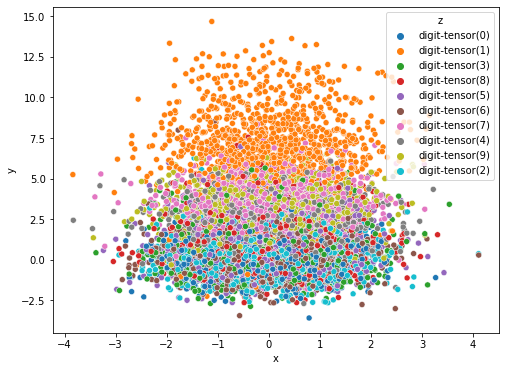

In [ ]:
import pandas as pd
import seaborn as sns
x = []
y = []
z = []
examples = enumerate(test_loader)
batch_idx, (test_data, testy) = next(examples)
test_data = test_data.to(device)
for i in range(10000):
    z.append(testy[i])
    # op = encoder_model.predict(np.array([test_data[i]]))
    
    mu, logvar = model.encoder(test_data[i])
    op = model.reparameterize(mu,logvar).cpu().detach().numpy()
    x.append(op[0][0])
    y.append(op[0][1])
df = pd.DataFrame()
df['x'] = x
df['y'] = y
df['z'] = ["digit-"+str(k) for k in z]
plt.figure(figsize=(8, 6))
sns.scatterplot(x='x', y='y', hue='z', data=df)
plt.show()

(10000, 2)


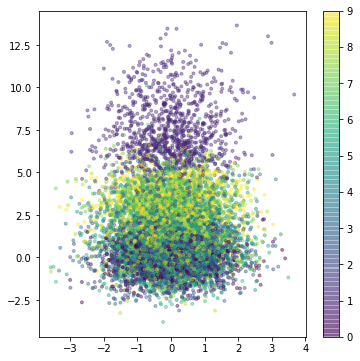

In [ ]:
test_data = torchvision.datasets.MNIST('/content/', train = False, transform=transforms.ToTensor(), download = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=10000, shuffle=True)
examples = enumerate(test_loader)
batch_idx, (data, y_test) = next(examples)
data.shape
data = data.to(device)
mu, logvar = model.encoder(data)

z_test = model.reparameterize(mu,logvar).cpu().detach().numpy()
# x = z_test[:,:10].reshape()
# y = z_test[:,10:]
print(z_test.shape)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:,0], z_test[:,1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

In [ ]:
z_test[:,1].shape

(1000,)

In [ ]:
random_sample = torch.randn(100, 20).to(device)
results = model.decoder(random_sample).view(-1,1,28,28)
path = '/content/drive/MyDrive/VAE/' + 'Sample_z_distribution_1' + '.png'
save_image(results.cpu(), path, nrow=10)